# RAMP on predicting cyclist traffic in Paris


## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Loading the data with pandas

First, download the data files from Kaggle, and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [3]:
data = pd.read_parquet(Path("data") / "train.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


We can check general information about different columns:

In [ ]:
data.info()

and in particular the number of unique entries in each column,

In [ ]:
data.nunique(axis=0)

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations:

In [ ]:
(
    data.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

In [4]:
external=pd.read_csv("data/external_data.csv")
external.head()

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN


In [ ]:
external.info()

In [5]:
missing_percent=external.isnull().sum()/len(external)*100
missing_percent[missing_percent>50]
len(missing_percent[missing_percent>50])

20

In [6]:
#convert to standard time format
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.round('3H')
external['date'] = pd.to_datetime(external['date'])

# merging on the timestamp column
merged_data = pd.merge(data, external, left_on='date', right_on='date', how='left')

In [7]:
merge_miss = merged_data.isnull().sum()/len(merged_data)*100
column_to_drop=merge_miss[merge_miss>50].index


In [8]:
merged_data.drop(columns=column_to_drop,inplace=True)


In [9]:
correlation = merged_data.corr()
correlation_target = abs(correlation['log_bike_count'])
low_corr_fea=correlation_target[correlation_target<0.02].index
merged_data.drop(columns=low_corr_fea,inplace=True)
print(merged_data.columns.tolist()[:])


/var/folders/3c/7ww0mhtj5s11vrq1wd4k_6zm0000gn/T/ipykernel_11330/3613253411.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = merged_data.corr()


['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count', 'date', 'counter_installation_date', 'coordinates', 'counter_technical_id', 'latitude', 'longitude', 'log_bike_count', 'numer_sta', 'pmer', 'cod_tend', 'ff', 't', 'td', 'u', 'vv', 'ww', 'w1', 'w2', 'cl', 'pres', 'raf10', 'rafper', 'per', 'etat_sol', 'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'nnuage1', 'ctype1', 'nnuage2', 'hnuage2']


/var/folders/3c/7ww0mhtj5s11vrq1wd4k_6zm0000gn/T/ipykernel_11330/451814299.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_data.corr(), annot=True, fmt=".2f")


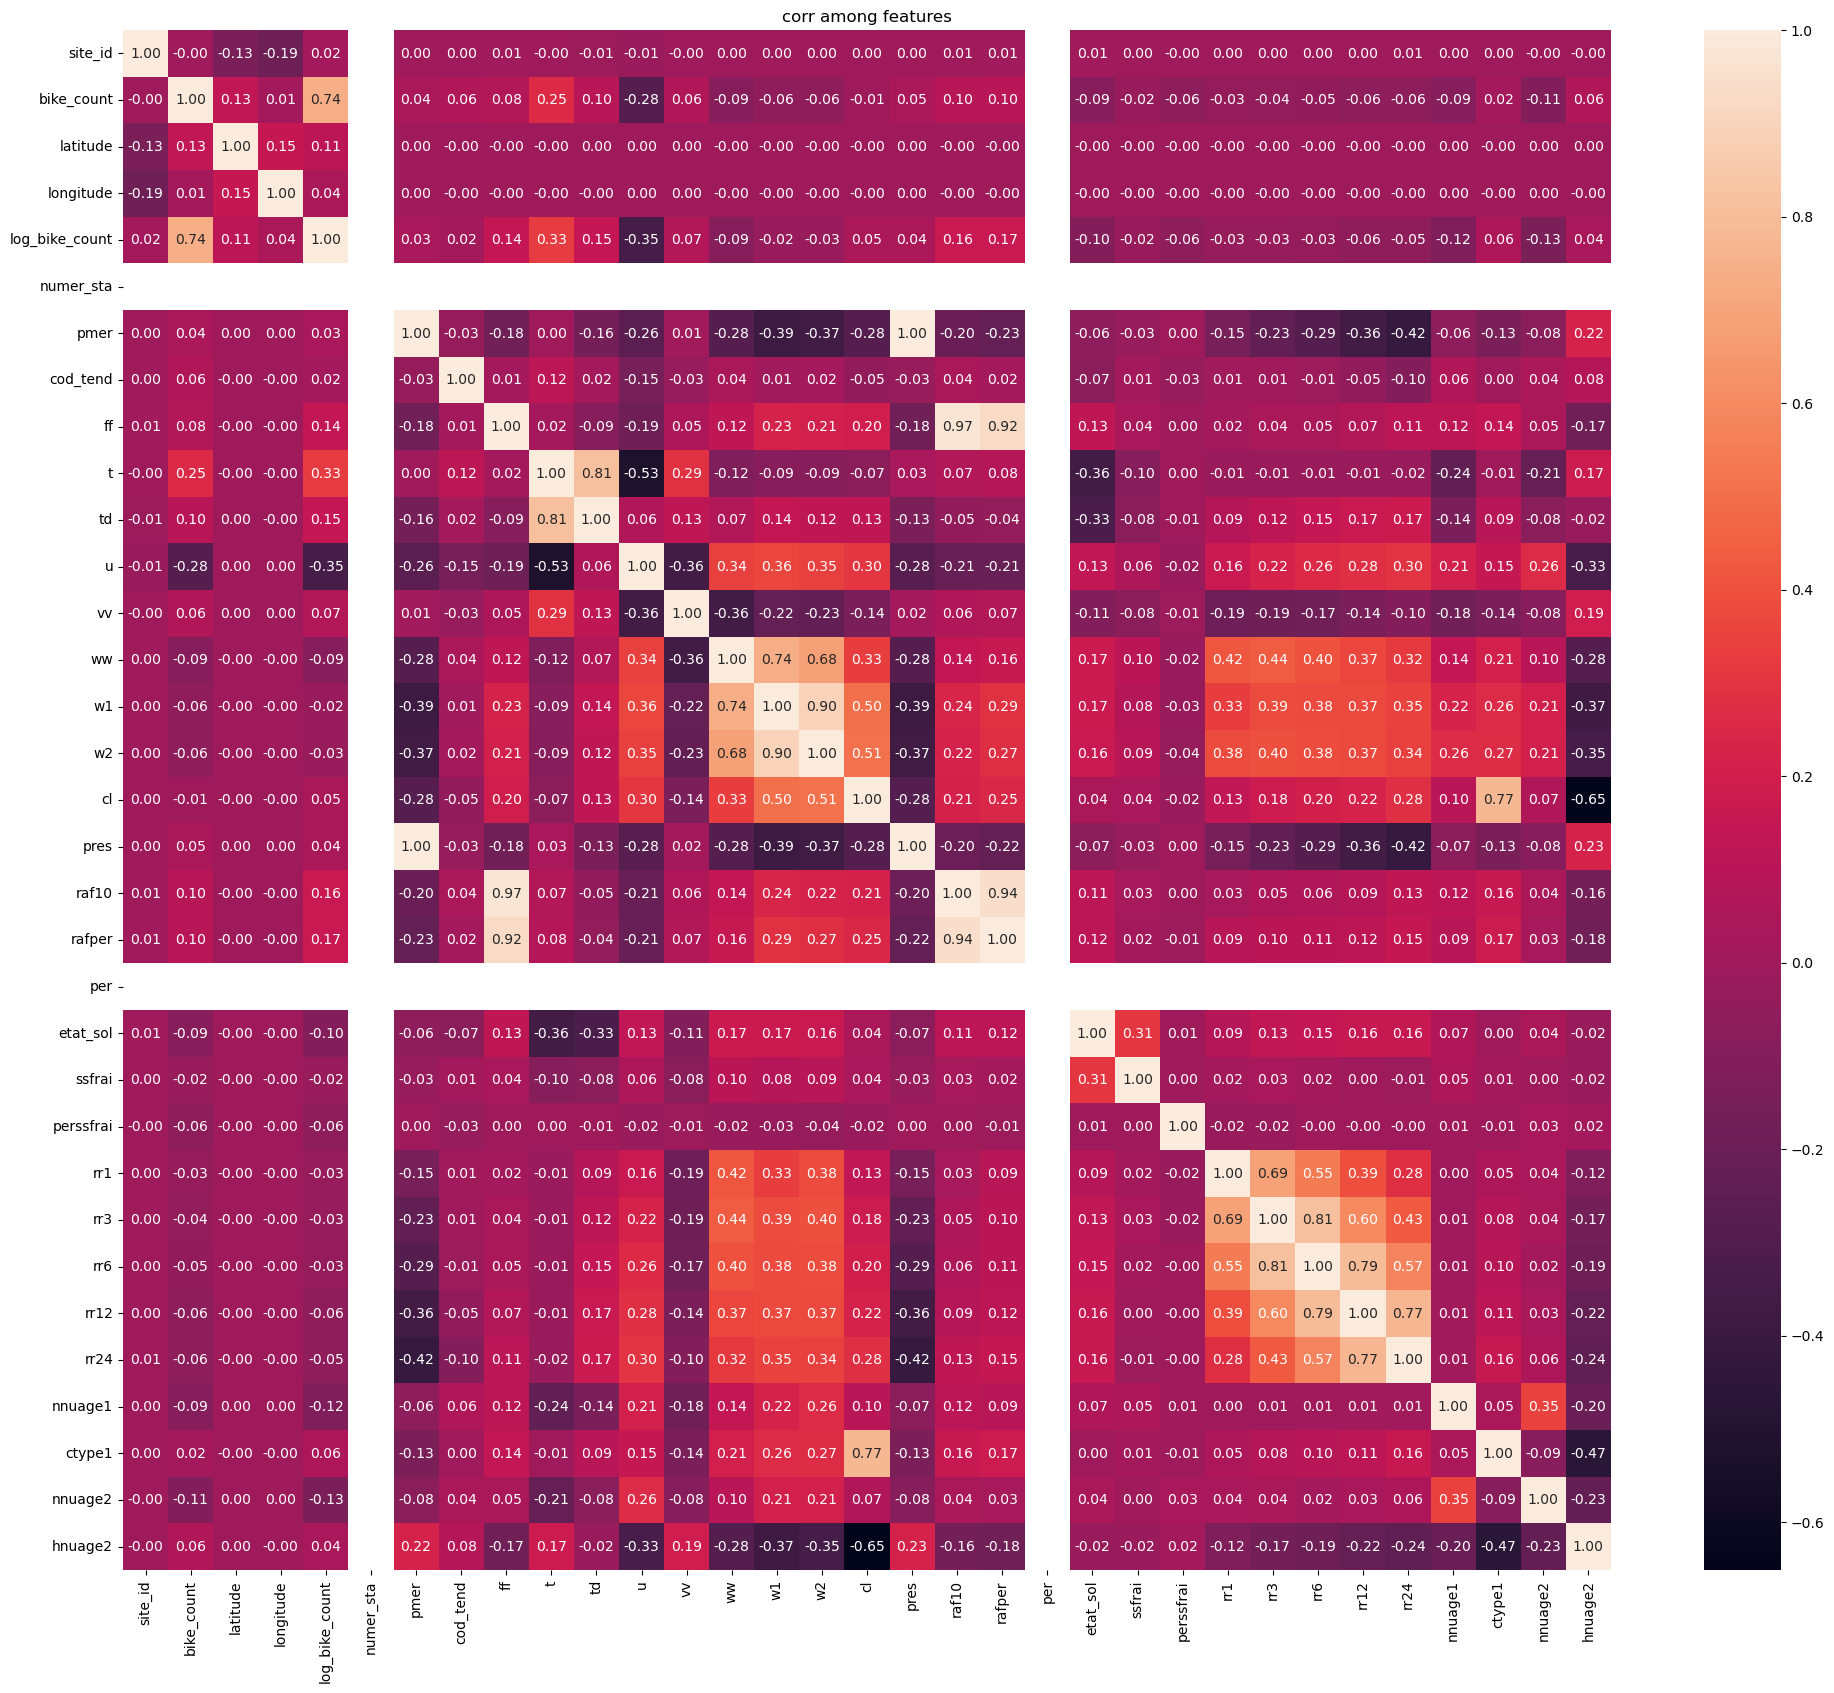

In [10]:
import seaborn as sns
plt.figure(figsize=(24, 20))
sns.heatmap(merged_data.corr(), annot=True, fmt=".2f")
plt.title('corr among features')
plt.show()

In [11]:
column_to_drop2=['counter_id', 'site_id','coordinates','counter_technical_id','numer_sta', 'pmer', 'cod_tend', 'td', 'ww', 'w1', 'w2', 'cl', 'pres', 'raf10', 'ff', 'per', 'ssfrai', 'rr1', 'rr6', 'rr12', 'rr24', 'nnuage1', 'ctype1']
merged_data.drop(columns=column_to_drop2,inplace=True)
#merged_data['cloud']=merged_data['nnuage1']*merged_data['ctype1']*merged_data['hnuage1']
merged_data['lag_1_hour']=merged_data['bike_count'].shift(3)
print(merged_data.columns.tolist()[:])

['counter_name', 'site_name', 'bike_count', 'date', 'counter_installation_date', 'latitude', 'longitude', 'log_bike_count', 't', 'u', 'vv', 'rafper', 'etat_sol', 'perssfrai', 'rr3', 'nnuage2', 'hnuage2', 'lag_1_hour']


/var/folders/3c/7ww0mhtj5s11vrq1wd4k_6zm0000gn/T/ipykernel_11330/1346243518.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_data.corr(), annot=True, fmt=".2f")


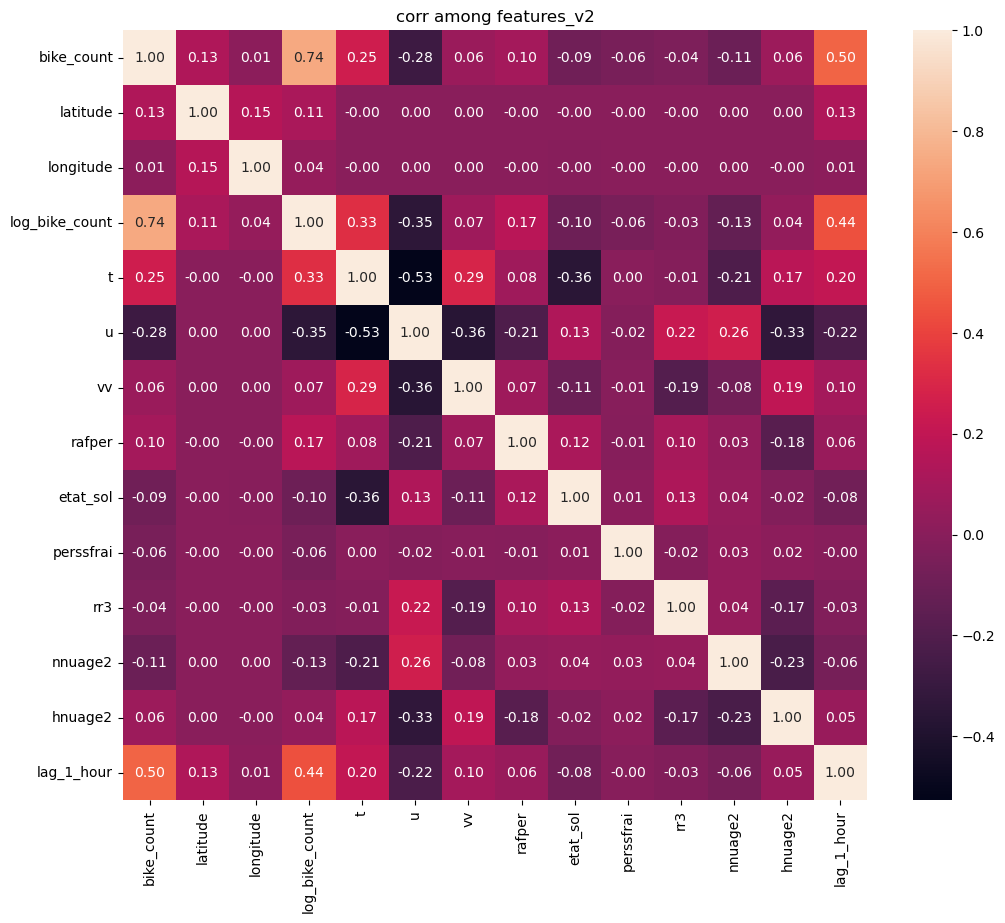

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(merged_data.corr(), annot=True, fmt=".2f")
plt.title('corr among features_v2')
plt.show()

numer_sta: 通常代表气象站的编号。
date: 观测的日期和时间。
pmer: 海平面气压。
tend: 气压趋势。
cod_tend: 气压趋势的编码。
dd: 风向（以度为单位）。
ff: 风速。
t: 温度。
td: 露点温度。
u: 相对湿度。
vv: 能见度。
ww: 当前天气状况的编码。
w1: 过去一小时天气状况的编码。
w2: 过去六小时天气状况的编码。
n: 云量。
nbas: 低云量。
hbas: 低云高度。
cl: 低层云的编码。
cm: 中层云的编码。
ch: 高层云的编码。
pres: 站点气压。
niv_bar: 气压水平。
geop: 地面以上某个固定高度的气压。
tend24: 24小时气压变化。
tn12: 过去12小时的最低温度。
tn24: 过去24小时的最低温度。
tx12: 过去12小时的最高温度。
tx24: 过去24小时的最高温度。
tminsol: 地表最低温度。
sw: 地面状态的编码。
tw: 地面温度。
raf10: 过去10分钟的最大阵风。
rafper: 观测期间的最大阵风。
per: 降水量。
etat_sol: 地面状态。
ht_neige: 雪高。
ssfrai: 雪的状态。
perssfrai: 过去一小时的降水量。
rr1: 过去一小时的降水量。
rr3: 过去三小时的降水量。
rr6: 过去六小时的降水量。
rr12: 过去十二小时的降水量。
rr24: 过去二十四小时的降水量。
phenspe1: 特殊气象现象的编码。
phenspe2: 特殊气象现象的编码。
phenspe3: 特殊气象现象的编码。
phenspe4: 特殊气象现象的编码。
nnuage1: 第一层云的云量。
ctype1: 第一层云的类型。
hnuage1: 第一层云的高度。
nnuage2: 第二层云的云量。
ctype2: 第二层云的类型。
hnuage2: 第二层云的高度。
nnuage3: 第三层云的云量。
ctype3: 第三层云的类型。
hnuage3: 第三层云的高度。
nnuage4: 第四层云的云量。
ctype4: 第四层云的类型。
hnuage4: 第四层云的高度。

# categorical columns pre-processing

In [12]:
category_cols = merged_data.select_dtypes(include=['object', 'category']).columns
for col in category_cols:
    print(f"{col} 有 {merged_data[col].nunique()} 个唯一值")


counter_name 有 56 个唯一值
site_name 有 30 个唯一值


# Visualizing the data


Let's visualize the data, starting from the spatial distribution of counters on the map

In [ ]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

Note that in this challenge, we consider only the 30 most frequented counting sites, to limit data size.

Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points:

In [ ]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].plot(x="date", y="bike_count")

Instead we aggregate the data, for instance, by week to have a clearer overall picture:

In [ ]:
mask = (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")

data[mask].groupby(
    pd.Grouper(freq="1w", key="date")
)[["bike_count"]].sum().plot()

While at the same time, we can zoom on a week in particular for a more short-term visualization,

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data["date"] > pd.to_datetime("2021/03/01"))
    & (data["date"] < pd.to_datetime("2021/03/08"))
)

data[mask].plot(x="date", y="bike_count", ax=ax)

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

In [ ]:
import seaborn as sns
ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

In [ ]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field:

In [13]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [14]:
merged_data["date"].head()

0   2020-09-01 03:00:00
1   2020-09-01 03:00:00
2   2020-09-01 03:00:00
3   2020-09-01 15:00:00
4   2020-09-01 18:00:00
Name: date, dtype: datetime64[ns]

In [15]:
_encode_dates(merged_data[["date"]].head())

,year,month,day,weekday,hour
0,2020,9,1,1,3
1,2020,9,1,1,3
2,2020,9,1,1,3
3,2020,9,1,1,15
4,2020,9,1,1,18


To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html):

In [16]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
sample_encoded = date_encoder.fit_transform(merged_data[["date"]]).head()
sample_encoded

,year,month,day,weekday,hour
0,2020,9,1,1,3
1,2020,9,1,1,3
2,2020,9,1,1,3
3,2020,9,1,1,15
4,2020,9,1,1,18


Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [17]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)

enc.fit_transform(sample_encoded[["hour"]])

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

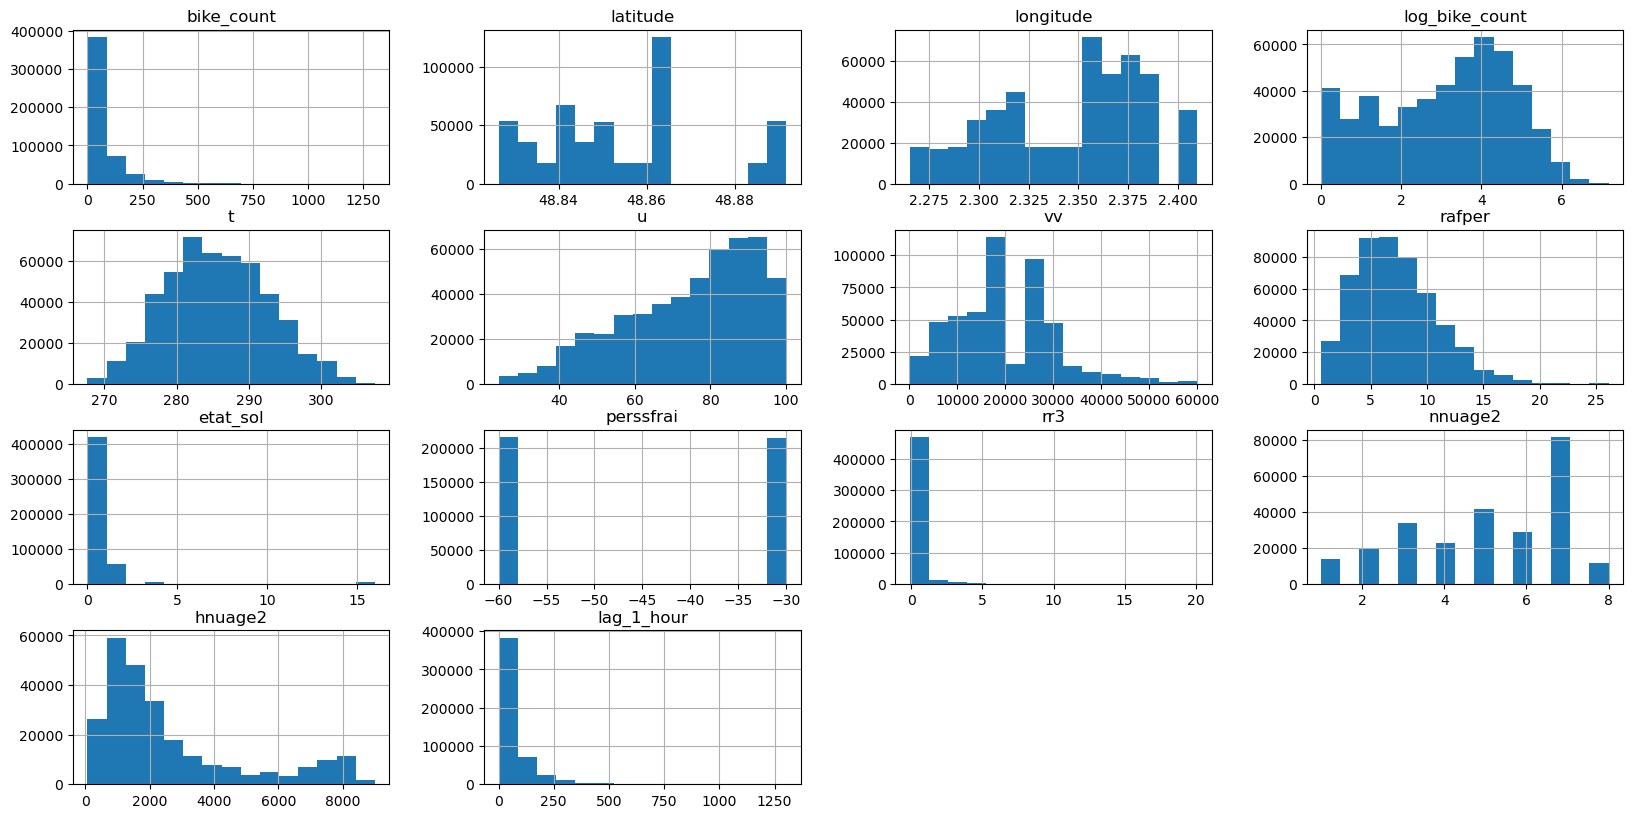

In [18]:
num_features = merged_data.select_dtypes(include=['int64', 'float64']).columns
merged_data[num_features].hist(bins=15, figsize=(20, 15), layout=(6, 4))
plt.show()

# LSTM model

In [20]:
import pandas as pd

# Assuming merged_data is your original DataFrame
# Use pd.get_dummies for one-hot encoding
encode_counter = pd.get_dummies(merged_data['counter_name'], prefix='counter')
encode_site = pd.get_dummies(merged_data['site_name'], prefix='site')

# Concatenate the encoded features
encoded_features = pd.concat([encode_counter, encode_site], axis=1)

# Concatenate the encoded DataFrame with the original data
df_encoded = pd.concat([merged_data.drop(['counter_name', 'site_name'], axis=1), encoded_features], axis=1)

#convert timestamp
df_encoded2= _encode_dates(df_encoded)



In [21]:
from sklearn.preprocessing import MinMaxScaler

# 假设 'target' 是你要预测的列
target = df_encoded['log_bike_count']

# 创建滑动窗口特征
window_size = 8*30  # 例如使用过去24小时的数据
features = []
labels = []

for i in range(window_size, len(df_encoded2)):
    features.append(df_encoded[i-window_size:i])
    labels.append(target[i])

# 将特征和标签转换为NumPy数组
features, labels = np.array(features), np.array(labels)

# 归一化特征
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features.reshape(-1, features.shape[-1])).reshape(features.shape)

# 分割数据集
train_size = 30 * 8
X_train, X_test = features_scaled[:train_size], features_scaled[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]



: 

In [ ]:
# 构建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X_train, y_train, epochs=100, batch_size=32)

In [ ]:
# 预测
y_pred = model.predict(X_test)

# 反归一化预测值和真实值（如果之前进行了归一化）
# y_test = scaler.inverse_transform(y_test)
# y_pred = scaler.inverse_transform(y_pred)

# 计算RMSE
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# random forest

In [22]:
train_size = 8 * 30
train_df, test_df = df_encoded[:train_size], df_encoded[train_size:]

X_train = train_df.drop('log_bike_count', axis=1)
y_train = train_df['log_bike_count']
X_test = test_df.drop('log_bike_count', axis=1)
y_test = test_df['log_bike_count']


In [28]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

# Assuming 'date' is the column you want to exclude
features_for_model = df_encoded2.drop(['log_bike_count'], axis=1)

# 假设 'target' 是你要预测的列
target = df_encoded2['log_bike_count']

# 创建滑动窗口特征
window_size = 24  # 例如使用过去24小时的数据
features = []
labels = []

for i in range(window_size, len(df_encoded2)):
    features.append(features_for_model.iloc[i - window_size:i].values)
    labels.append(target.iloc[i])

# 将特征和标签转换为NumPy数组
#features, labels = np.array(features), np.array(labels)

features_array = [np.array(feature) for feature in features]

# Convert 'Timestamp' dtype to numerical dtype for each array in the list
features_numeric = [feature.astype(float) for feature in features_array]

# 归一化特征
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape each array in the list before applying scaling
features_scaled = [scaler.fit_transform(feature.reshape(-1, feature.shape[-1])).reshape(feature.shape) for feature in features_numeric]

# 归一化特征
#scaler = MinMaxScaler(feature_range=(0, 1))
#features_scaled = scaler.fit_transform(features_numeric.reshape(-1, features_numeric.shape[-1])).reshape(features_numeric.shape)

# 分割数据集
train_size = 30 * 8
X_train, X_test = features_scaled[:train_size], features_scaled[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# 使用 RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


: 

In [ ]:
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

## Linear model

Let's now construct our first linear model with [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). We use a few helper functions defined in `utils.py` of the starting kit to load the train set.

In [ ]:
import utils
X = merged_data.drop(columns=['log_bike_count','bike_count'],axis=1)
y = merged_data['log_bike_count']

X.head(2)

and

In [ ]:
y

Where `y` contains the `log_bike_count` variable. 

To test our baseline estimator, we create a validations set from the training set. Note that, during modeling and exploring the data, we always recommend using cross validation rather than a single train / validation split to evaluate your first results, because this will bring more stability and generalization.

We create the validation set by simply slicing the last 30 days of the training set:

In [ ]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [ ]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

In [ ]:
_encode_dates(X_train[["date"]]).columns.tolist()

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

We then evaluate this model with the RMSE metric,

In [ ]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [ ]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations (we transform the logarithmic bike counts back to their original unit):

In [ ]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

In [ ]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_valid, "y_pred": pipe.predict(X_valid)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html):

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores:

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")